In [1]:
import numpy as np   
import matplotlib.pyplot as plot
%matplotlib inline

# Ambient state

In [2]:
from pycfd.reference.atmospheric_flow import stratification_profiles, saturation_calculation

ambient_stratification = stratification_profiles.Soong1973Dry()

T_e = lambda z: ambient_stratification.temp(z)
p_e = ambient_stratification.p

# Model integration

In [3]:
import odespy, numpy
from pyclouds import cloud_equations, plotting, cloud_microphysics
from pyclouds.common import Var

In [4]:
g = ambient_stratification.g
R_d = ambient_stratification.gas_properties.R()
cp_d = ambient_stratification.gas_properties.cp()

environment = ambient_stratification
constants = {'R_d': R_d, 'cp_d': cp_d, 'g': g }

In [9]:
z0 = 750.
z_points = numpy.linspace(z0, 10e3, 5000)

w0 = 3.0
r0 = 100.
T0 = ambient_stratification.temp(z0) + 0.1
p0 = ambient_stratification.p(z0)
# r, w, T, q_v, q_r, q_l, q_i
initial_condition = Var.make_state(r=r0, w=w0, T=T0, q_v=0.012, q_l=0.0, q_i=0.0, p=p0)

In [10]:
beta = 0.2

SolverClass = odespy.Euler
constraint = 'isobaric'

microphysics = cloud_microphysics.FiniteCondensationTimeMicrophysics(model_constraint=constraint,)
cloud_model = cloud_equations.FullThermodynamicsCloudEquations(environment=environment, gamma=1.0, D=0.1, beta=beta, microphysics=microphysics)
profile1 = cloud_model.integrate(initial_condition, z_points, SolverClass=SolverClass)

microphysics = cloud_microphysics.FiniteCondensationTimeMicrophysics(model_constraint=constraint, disable_rain=True)
cloud_model = cloud_equations.FullThermodynamicsCloudEquations(environment=environment, gamma=1.0, D=0.1, beta=beta, microphysics=microphysics)
profile2 = cloud_model.integrate(initial_condition, z_points, SolverClass=SolverClass)




Integration stopped: vertical velocity dropped to zero
-0.274905231507
ForwardEuler terminated at t=1636.33
Integration stopped: vertical velocity dropped to zero
-0.274905231507
Integration stopped: vertical velocity dropped to zero
-0.0823486943866
ForwardEuler terminated at t=1473.49
Integration stopped: vertical velocity dropped to zero
-0.0823486943866


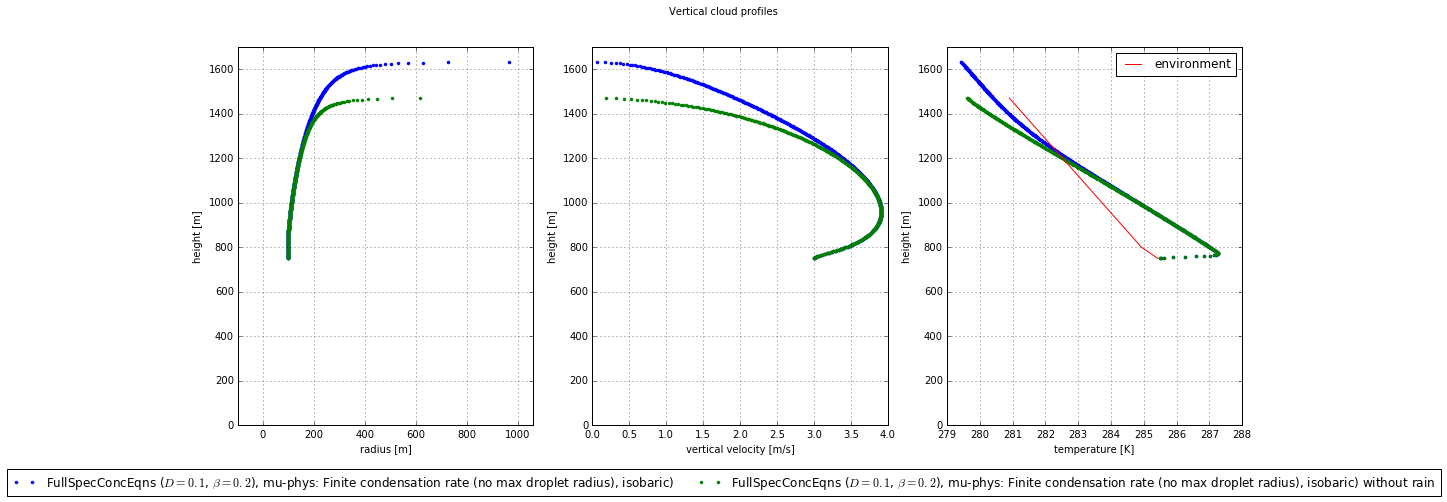

In [11]:
fig = plotting.plot_profiles([profile1, profile2], ['r', 'w', 'T'])
fig.savefig('/home/zmaw/m300464/Desktop/cloudmodel_profile.pdf')

(0, 1)

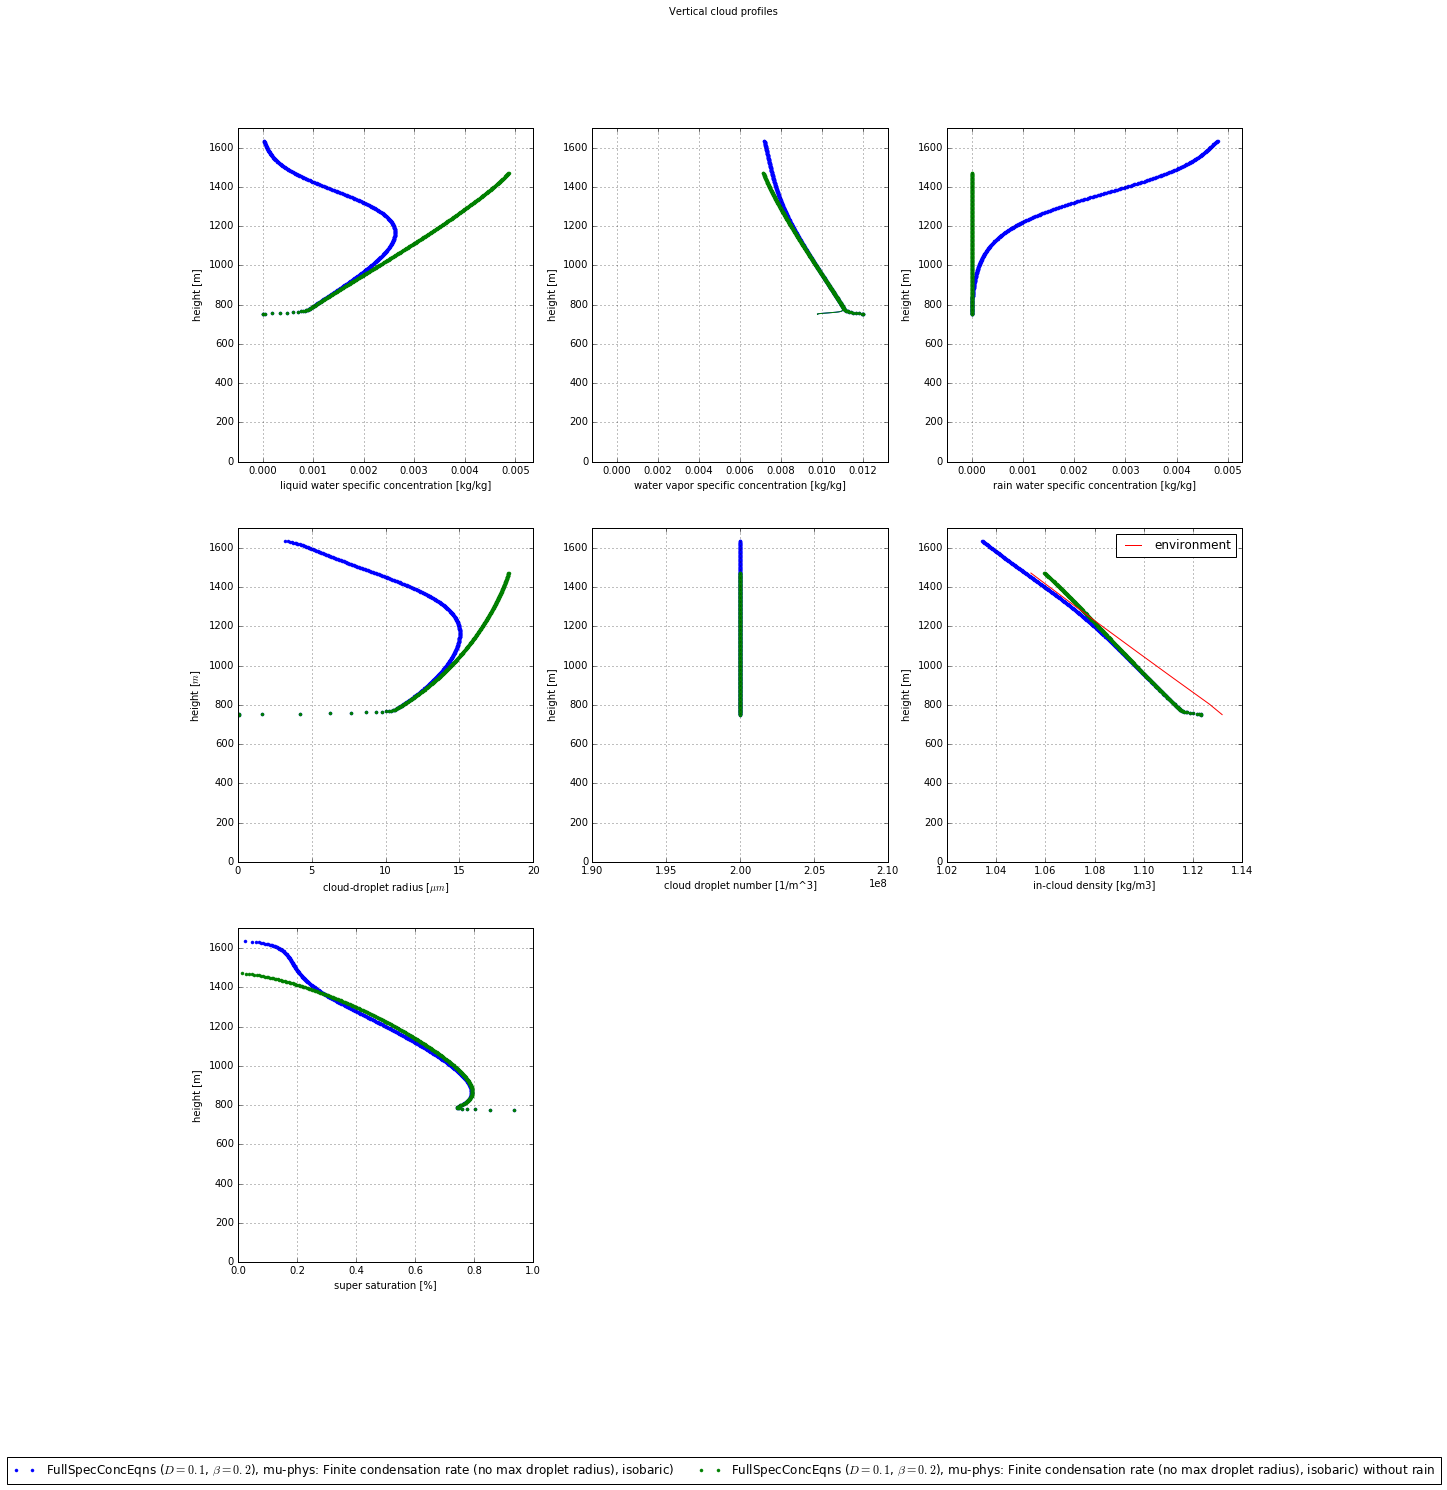

In [12]:
fig = plotting.plot_profiles([profile1, profile2], ['q_l', 'q_v', 'q_r', 'r_c', 'Nc', 'rho_c', 'Sw', ])
fig.gca().set_xlim(0,1)

(0, 2e-05)

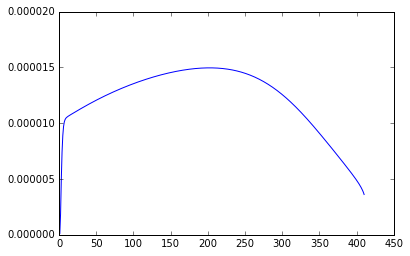

In [9]:
t_mphys = profile1.extra_vars['t_substeps']
r_c__mphys = profile1.extra_vars['r_c']

plot.plot(r_c__mphys)
plot.ylim(0, 2.0e-5)

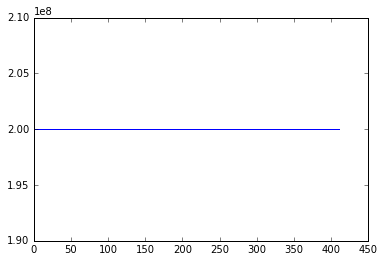

In [10]:
Nc__mphys = profile1.extra_vars['Nc']

plot.plot(Nc__mphys)


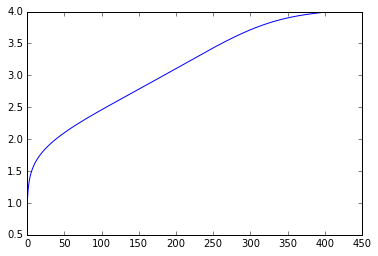

In [11]:
w_r__mphys = profile1.extra_vars['w_r']

plot.plot(w_r__mphys)

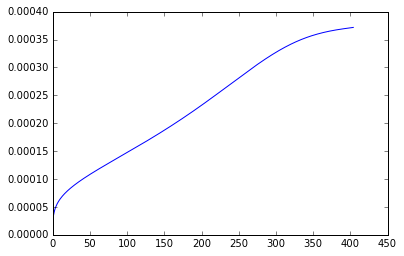

In [15]:
lambda_r__mphys = np.array(profile1.extra_vars['lambda_r'])

plot.plot(1./lambda_r__mphys)

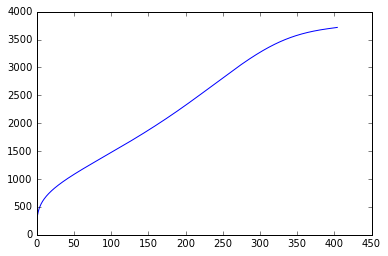

In [13]:
Nr__mphys = profile1.extra_vars['Nr']
plot.plot(Nr__mphys)